# Produces masks and bounding boxes from prompts using a segRS model

The Segment for remote sensing (segRS) predicts object instance masks and bounding boxes given prompts that indicate the desired object. 

Necessary imports and helper functions for displaying image, ground truth mask and predicted image.

In [1]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from segRS import segRS
from PIL import Image
from tqdm import tqdm
from PIL import ImageDraw
import torch

/Users/akashah.shabbir/miniconda3/envs/rsenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/akashah.shabbir/miniconda3/envs/rsenv/lib/python3.8/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
# display images with boxes and maskes also displays confidence score 
def display_image_boxes_masks(image, masks, boxes, logits, text, random_color=True):
    
    #storing different color for every segmentation
    color_ar = [] #colors array 
    for mask in masks: 
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        color_ar.append(color)        
    
    #creating masks
    for idx, mask in enumerate(masks): 
        h, w = mask.shape[-2:]
        annotated_frame_pil = image.convert("RGBA")
        
        mask_image = mask.reshape(h, w, 1) * color_ar[idx].reshape(1, 1, -1)
        mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")
        image = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off') 
    
    #drawing boxes and adding text showing confidence score 
    for idx, (box, logit) in enumerate(zip(boxes, logits)):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min
        
        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor=color_ar[idx], linewidth=1)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min-20, f"{text}: {confidence_score}", fontsize=5, color="#FFFFFF",backgroundcolor =color_ar[idx], verticalalignment='top',bbox=dict(facecolor=color_ar[idx], alpha=0.5, pad=0.5,edgecolor='none'))

    plt.show()
               

# Example image

In [9]:

image = Image.open("sample/plane.png").convert("RGB")

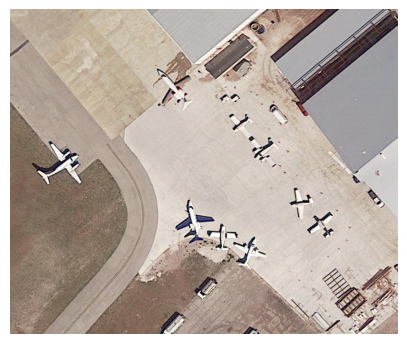

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

First, load the segRS model. This will set the path to point to the SAM, groundingDINO and remoteCLIP checkpoints. 

In [11]:
import sys
sys.path.append("..")

model = segRS()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /Users/akashah.shabbir/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.
ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.
ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


Predict with `predict`. The baseline model returns masks, boxes and logits.

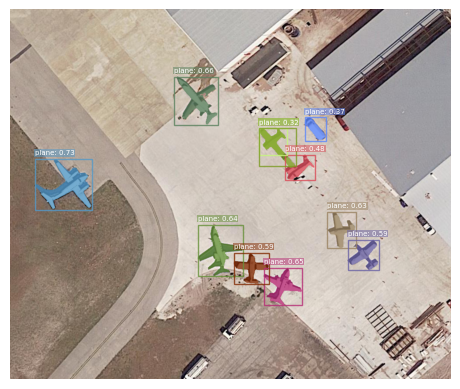

In [12]:
text_prompt = "plane"
masks, boxes, phrases, logits = model.predict(image, text_prompt)

# Displaying image with predicted masks and boxes
display_image_boxes_masks(image, masks, boxes, logits,text_prompt)

Predict with `predict_segRS`. The segRS model returns masks, boxes and mask logits . Note that first query is positive while other 3 queries should be negative examples.

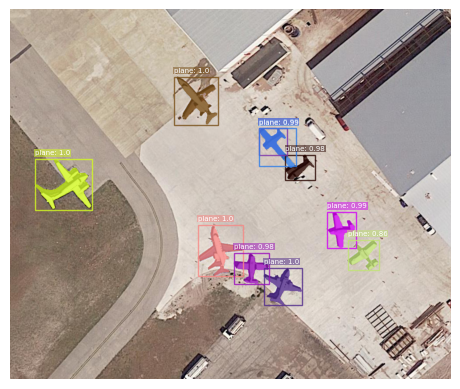

In [14]:

text_prompt = "plane"
text_queries = [
    "A plane", 
    "A helicopter", 
    "A ship", 
    "A car",
]
masks, boxes, phrases, logits = model.predict_segRS(image, text_prompt,text_queries)

# Displaying image with predicted masks and boxes 
display_image_boxes_masks(image, masks, boxes, logits,text_prompt)